In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from Models.VAE_128 import ConvolutionalVariationalAutoencoder, VariationalInference
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from IPython.display import clear_output
import matplotlib.pyplot as plt


In [2]:
# Create network
class DNN(nn.Module):
    def __init__(self, probe_size, latent_size):
        super(DNN, self).__init__()
        dropout_rate = 0.3
        self.network = nn.Sequential(
            nn.Linear(probe_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, latent_size)
        )

    # Feed-forward
    def forward(self, x):
        return self.network(x)

# Example usage:
# Create a model with an output size of 32
output_dim = 32
model = DNN(probe_size=7,latent_size=26)

# Test with a random input of 7 floats
dummy_input = torch.randn(1, 7)
output = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(model)

Input shape: torch.Size([1, 7])
Output shape: torch.Size([1, 26])
DNN(
  (network): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=26, bias=True)
  )
)


In [3]:
# Import probe data
probe_data = np.transpose(np.load('data_numpy\extracted_probe_data128.npy'))

# Standardization of probe data
scaler = StandardScaler() # Subtracts mean and divides by standard deviation
probe_data_scaled = scaler.fit_transform(probe_data)

In [4]:
# Import trained VAE
trained_network_path = "model_26_e3_0.75_200epochs/model_weights_26_e3_0.75_200epochs.pth"

# Initialize vae
latent_features = 26
input_size = 128
vae = ConvolutionalVariationalAutoencoder(input_size, latent_features)
vae.load_state_dict(torch.load(trained_network_path,map_location=torch.device('cpu')))
vi = VariationalInference(beta=0.75)

# Load images
images = np.load('data_numpy/density_large128.npy')
x = torch.tensor(images, dtype=torch.float32) # (N, W, H)

# Unsquezze if necessary
if x.ndim == 3:
    x = x.unsqueeze(1)


# Generate data set of latent features from the images
with torch.no_grad():
    outputs = vae(x)
    z = outputs['z'] # Getting the latent space samples
    latent_features = z.cpu().numpy()

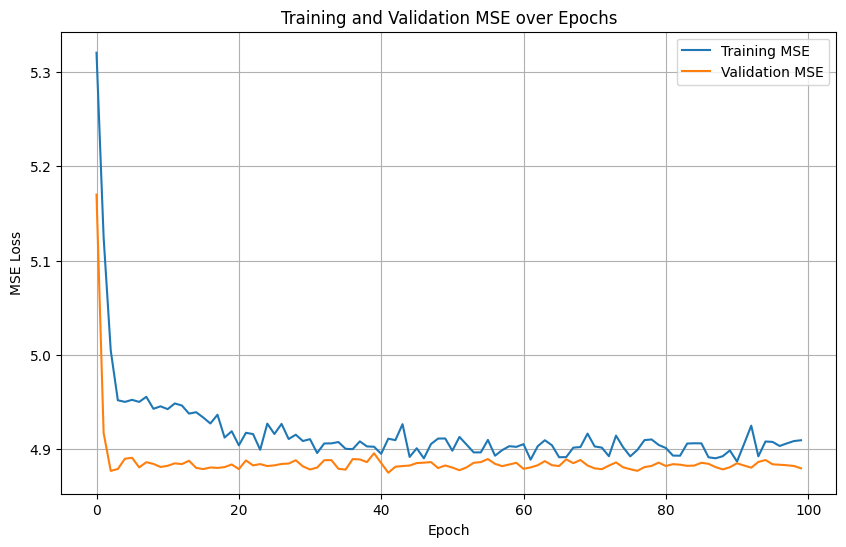

Epoch [100/100], Train MSE: 4.9097, Val MSE: 4.8799


In [5]:


def MSE_curves(train_mse, val_mse):
    """
    Training curves

    """
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(train_mse, label='Training MSE')
    plt.plot(val_mse, label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation MSE over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


# Prepare data
# probe_data is (7, 501) -> (501, 7)
# latent_features is (26, 501) -> (501, 26)
X = torch.tensor(probe_data, dtype=torch.float32) 
y = torch.tensor(latent_features, dtype=torch.float32)

# Create Dataset
dataset = TensorDataset(X, y)

# Split into Train (80%) and Validation (20%)
split = 0.8
train_size = int(split * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
output_dim = 26 # Based on latent_features shape (26 features)
model = DNN(probe_size=7, latent_size=output_dim)

#Loss and optimizer
criterion = nn.MSELoss() # Mean-squared error
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer lr = 10e-3

# 100 epochs
num_epochs = 100

# Lists to store metrics
train_mses = []
val_mses = []


# Training loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    epoch_mse = 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        
        # Loss
        mse_loss = criterion(predictions, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()
        
        # Add MSE to epoch
        epoch_mse += mse_loss.item()
    
    # Average over batches
    train_mses.append(epoch_mse / len(train_loader))

    # Validation Phase
    model.eval()
    val_epoch_mse = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            mse_loss = criterion(predictions, batch_y)
            
            val_epoch_mse += mse_loss.item()
    
    # Add to val
    val_mses.append(val_epoch_mse / len(val_loader))
    
    # Plot while training
    if (epoch + 1) % 5 == 0:
        MSE_curves(train_mses, val_mses)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train MSE: {train_mses[-1]:.4f}, Val MSE: {val_mses[-1]:.4f}')

In [6]:
# Save training curve

"""# Re-plot the final data to save it
plt.figure(figsize=(10, 6))
plt.plot(train_mses, label='Training MSE')
plt.plot(val_mses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE over Epochs')
plt.legend()
plt.grid(True)

# Save as PDF before showing
plt.savefig('training_validation_mse.pdf')
plt.show()"""

"# Re-plot the final data to save it\nplt.figure(figsize=(10, 6))\nplt.plot(train_mses, label='Training MSE')\nplt.plot(val_mses, label='Validation MSE')\nplt.xlabel('Epoch')\nplt.ylabel('MSE Loss')\nplt.title('Training and Validation MSE over Epochs')\nplt.legend()\nplt.grid(True)\n\n# Save as PDF before showing\nplt.savefig('training_validation_mse.pdf')\nplt.show()"